# Forward modeling

Here is a notebook to show how to use the modeling and some plotting and stats functions in my library. I will have in the same folder another notebook that will allow for some automation with a grid search variant of this.

# Importing data to be modeled

## Cleaned observed data and the polygon that is the basis of the model

    -LINE: The Dataframe of the line to be modeled 
    -SHAPES: The Dataframe of the shape to use for modeling

In [54]:
from source.load_data import path_to_df # this function finds if a file has a header and what the delimeter is
from pathlib import Path # Path library imported to handle data importation

SHAPE_DIR = './shapes' # directory where the shapefile is stored for modeling
LINE_DIR = './patches' # directory where cleaned line data is stored for modeling

#path_to_df function does as it says, it takes a Path object and imports the file in as a pandas dataframe and 
#figures out if a header exists and the row it is in as well as things like the delimiting character. 
#raw=False is somthing specific to the drone mag importation.

#polygon that defines the magnetic anomaly
SHAPE = path_to_df(Path(f'{SHAPE_DIR}/line_56a_shape3.utm'),raw=False) #any file in the shapes dir can be used. 

# line to be modeled 
LINE = path_to_df(Path(f'{LINE_DIR}/example_line.csv'),raw=False)

## now import the rest of the hyperparameters for the model
 
#### These are the parameters needed to create a PloufModel class

    -TOPS: the top bounds in meters of the shape
    -BOTTOM: the bottom bound in meters of the shape
    -INC: the paleoinclination from the surveyed location
    -DEC: the paleodeclination from the surveyed location
    -INT: the magnetic intensity for the model


In [55]:
TOPS = 40 #m
BOTTOM= 51 #m
INC= -67 #deg
DEC= 177 #deg
INT= 0.5 #Amp/m

### importing the PloufModel class which takes parameters and has a methods for working with the model results


In [56]:
from source.model_data import PloufModel

model = PloufModel(
    line = LINE,
    shape= SHAPE,
    top_bound= TOPS,
    bottom_bound= BOTTOM,
    inclination= INC,
    declination= DEC,
    intensity= INT
)

#### Checking the parameters imported into the PloufModel object

In [57]:
model.Parameters
# Notice that the residuals and results parameters are empty

{'bottom_bound': 51,
 'declination': 177,
 'inclination': -67,
 'intensity': 0.5,
 'line':            Long        Lat        Mag_nT        Easting      Northing  \
0   -116.598371  36.768727 -1.637090e-11  535843.354906  4.069292e+06   
1   -116.598372  36.768747 -2.200173e-01  535843.289625  4.069294e+06   
2   -116.598373  36.768767  6.002065e-02  535843.223230  4.069297e+06   
3   -116.598373  36.768786  4.393628e-01  535843.156118  4.069299e+06   
4   -116.598374  36.768806  4.194232e-01  535843.088408  4.069301e+06   
..          ...        ...           ...            ...           ...   
505 -116.598632  36.778650 -1.005358e-01  535815.491836  4.070393e+06   
506 -116.598633  36.778669 -5.263217e-01  535815.371334  4.070395e+06   
507 -116.598634  36.778689 -5.508618e-01  535815.243523  4.070397e+06   
508 -116.598636  36.778708 -7.539577e-02  535815.107458  4.070399e+06   
509 -116.598637  36.778727  3.456080e-11  535814.956698  4.070401e+06   

        Heading Dir  
0    178.2

#### Mapping the imported line and shape to make sure they are what you think

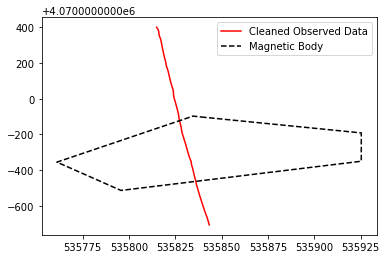

In [58]:
# plot_line_polygon does just that it plots the observed line and polygon that was imported above.
from source.plot_data import plot_line_and_polygon

plot_line_and_polygon(model)

### Now run the Plouf forward model using the imputs above

In [59]:
#run the model
model.run_plouf()

#### Check the results

In [60]:
model.results

,mag,ydist,xdist
0,0.653066,-558.786384,15.444474
1,0.649290,-556.599793,15.379193
2,0.644881,-554.412529,15.312798
3,0.639817,-552.233719,15.245686
4,0.634015,-550.046184,15.177976
...,...,...,...
505,0.566857,541.897335,-12.418596
506,0.560930,544.013843,-12.539099
507,0.555045,546.145489,-12.666910
508,0.549242,548.277208,-12.802975


### Plot the results against the observed

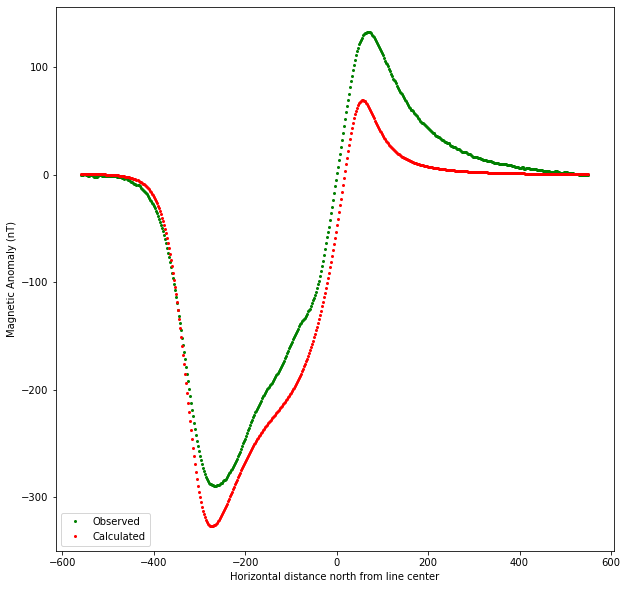

In [61]:
# the plot model function takes in the model object and plots the imported line versus the results
from source.plot_data import plot_model

plot_model(model)

#### plotting the residuals

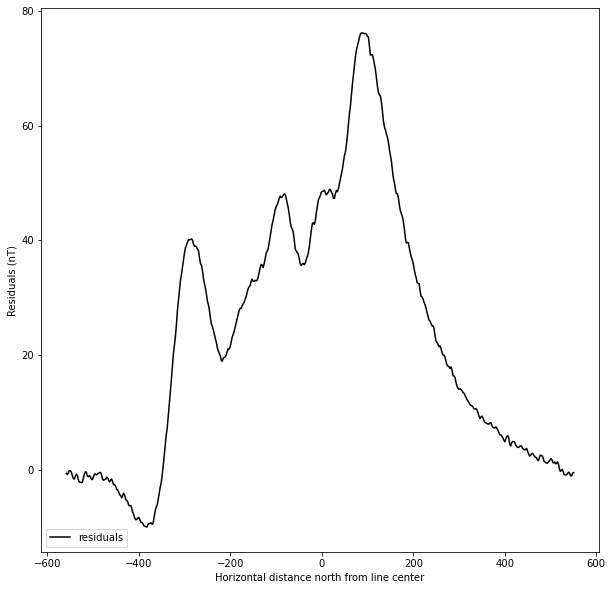

In [62]:
#since we have the observed data and the results above we can also plot the residuals or the difference between them
from source.plot_data import plot_residuals

plot_residuals(model)

### Using the stats.py functions we can pass in the PloufModel and compute comparison statistics using the residuals

Root Mean Square Error

In [63]:
from source.stats import get_rmse,get_abs_max_error
rmse = get_rmse(model)
        
print("RMSE: ",rmse)

RMSE:  32.44046910437764


Absolute Maximum Error

In [64]:
abs_max_err = get_abs_max_error(model)

print("abs max error: ", abs_max_err)

abs max error:  76.17947324188638


K-S Test


 Splitting data into 10 bins
Confidence Table:
   max difference  degrees of freedom  at 95% confidence
0        0.452941                 509           0.060281


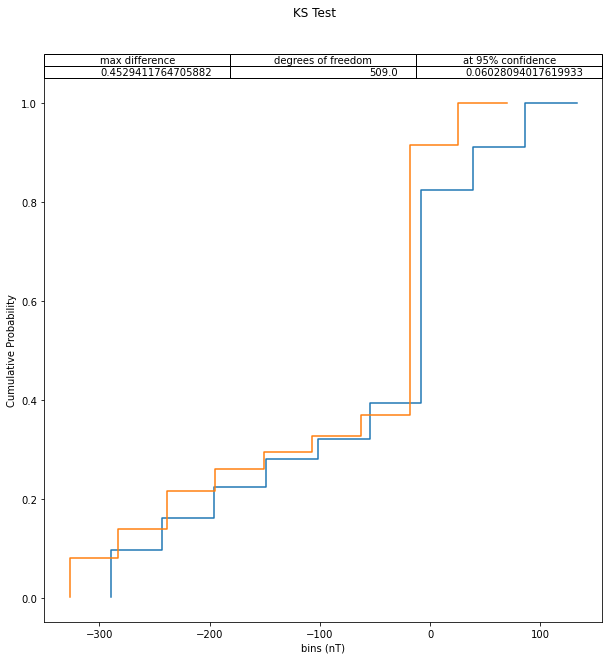

In [65]:
# K-S test is another way to compare observed data and models. Google has alot of good pages explaining it. 
from source.stats import ks_test

ks_test(model,bins=10)

In [66]:
# Durban watson looks to see if there is any "autocorrelation" or systematic error in the model results. 
# The value ranges for DW numbers can be looked up but I believe it should be around 2.
# this lower value tells me there is error in my model. most likely my polygon shape is not able to explain part of 
# the observed signal
from source.stats import get_durban_watson

get_durban_watson(model)

0.0005083809603167508